In [1]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import evofr as ef
import matplotlib.pyplot as plt

In [2]:
# Getting data
raw_seq = pd.read_csv("../mlr-fitness/data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../mlr-fitness/data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")

In [3]:
escape_scores = pd.read_csv("../../ncov-escape/escape-score/escape_scores.tsv", sep="\t")

def prep_escape_scores(escape_scores, variant_freqs):
    # Index by variant name
    escape_scores = escape_scores.rename(columns={"seqName": "variant"}).set_index("variant")
    escape_scores = (escape_scores[["immune_escape", "ace2_binding"]]
                     .replace("?")
                     .astype({"immune_escape":"float", "ace2_binding": "float"}))
    
    # Find scores of interest and parents
    var_names = [v for v in variant_freqs.var_names if v in escape_scores.index]
    escape_scores = escape_scores.loc[var_names] # Need all variants to be present...
    escape_scores["parent"] = escape_scores.index.map(variant_freqs.parent_map)
    
    # Get delta between parents and children
    def get_parent_delta(x, col="immune_escape"):
        variant = x.name
        parent = x.parent
        # If parent and child are present generate contrast
        if parent in escape_scores.index:
            return escape_scores.loc[variant][col] - escape_scores.loc[parent][col]
        # Gotta figure out how to deal with the nans
        return np.nan

    # Generate delta columns
    escape_scores["delta_immune_escape"] = escape_scores.apply(lambda x: get_parent_delta(x, "immune_escape"), axis=1)
    escape_scores["delta_ace2_binding"] = escape_scores.apply(lambda x: get_parent_delta(x, "ace2_binding"), axis=1)
    return escape_scores

escape_scores = prep_escape_scores(escape_scores, variant_frequencies)
escape_scores

,immune_escape,ace2_binding,parent,delta_immune_escape,delta_ace2_binding
variant,,,,,
BA.2.1,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.2.10,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.2.10.1,-0.000090,-0.00000,BA.2.10,0.000000,0.00000
BA.2.12,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.2.12.1,0.171804,-0.12693,BA.2.12,0.171894,-0.12693
...,...,...,...,...,...
BQ.1.6,0.630694,0.66401,BQ.1,0.000000,0.00000
XAS,0.386325,0.55831,BA.2,0.386325,0.55831
XAZ,0.386325,0.55831,BA.2,0.386325,0.55831


In [4]:
ga_df = pd.read_csv("../mlr-fitness/estimates/growth_advantages.tsv", sep="\t")
ga_delta_df = pd.read_csv("../mlr-fitness/estimates/growth_advantages_delta.tsv", sep="\t")

In [5]:
def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [16]:
import matplotlib
from matplotlib.cm import coolwarm, bwr
from matplotlib import colors
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 26
       }

matplotlib.rc('font', **font)

In [17]:
class MidpointNormalize(colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

    def inverse(self, value):
        y, x = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y)
    
cmap = bwr


In [18]:
from sklearn.linear_model import LinearRegression

def add_regression(ax, raw_x, raw_y, show_r_square=True):   
    
    # Processing data
    is_x_obs = ~np.isnan(raw_x) # Find where nan
    
    # Reshape data for input
    x = raw_x[is_x_obs].reshape((-1,1))
    y = raw_y[is_x_obs]
    
    # Define and fit linear regression
    model = LinearRegression()
    model.fit(x, y)
    
    # Compute R^2
    r_square = model.score(x, y)
     
    # Plot line of axis
    y_pred = model.predict(x)
    
    ax.plot(x, y_pred, color="k")
    
    if show_r_square:
        ax.text(0.05, 0.95, fr"$R^2$: {r_square.round(2)}", 
                horizontalalignment='left', 
                verticalalignment='top',
                transform=ax.transAxes)
    
    return model, r_square

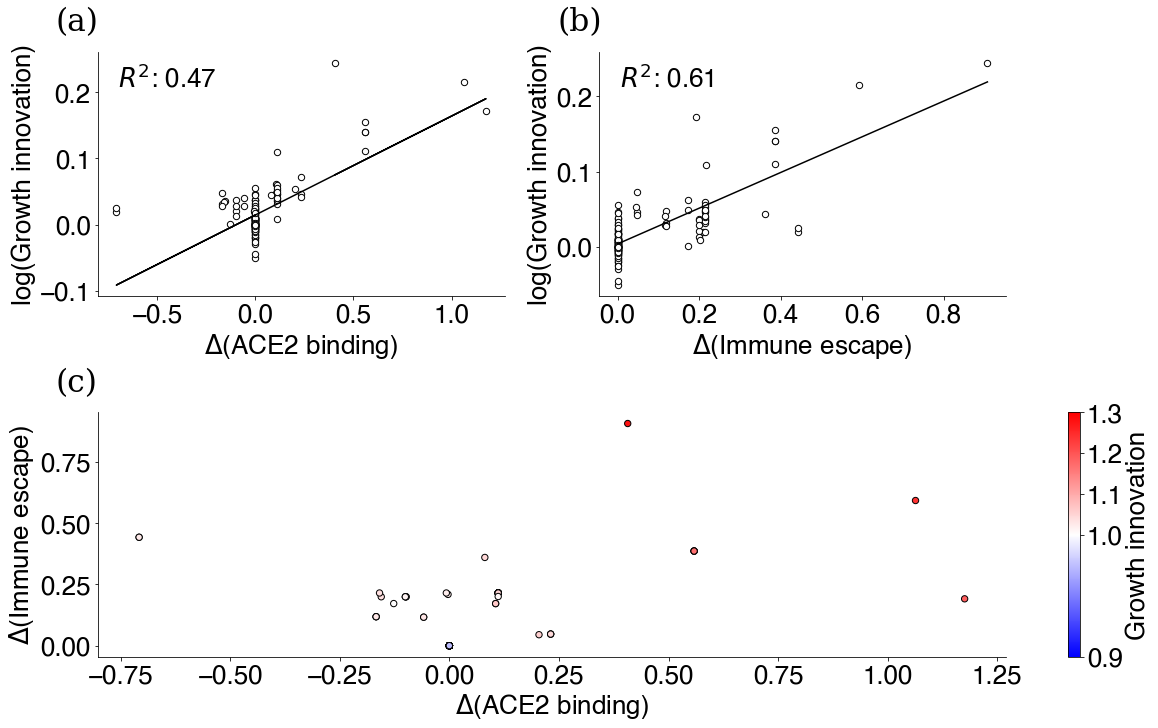

In [22]:
fig = plt.figure(figsize=(16, 10),  constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)

df = escape_scores.reset_index().merge(ga_delta_df, how="left")
log_ga_delta = np.log(df.median_ga_delta.values)
ga_delta = df.median_ga_delta.values

# Delta ACE2 v. Relative Fitness
ax_binding = fig.add_subplot(gs[0,0]); simple_axis(ax_binding)
ax_binding.scatter(df.delta_ace2_binding, log_ga_delta, ec = "k", color="w", s=40)
add_regression(ax_binding, df.delta_ace2_binding.values, log_ga_delta,)
ax_binding.set_xlabel(r"$\Delta$(ACE2 binding)")
ax_binding.set_ylabel("log(Growth innovation)")

# Delta Immune escape v. Relative Fitness
ax_es = fig.add_subplot(gs[0,1]); simple_axis(ax_es)
ax_es.scatter(df.delta_immune_escape, log_ga_delta, ec = "k", color="w", s=40)
add_regression(ax_es, df.delta_immune_escape.values, log_ga_delta,)

ax_es.set_xlabel(r"$\Delta$(Immune escape)")
ax_es.set_ylabel("log(Growth innovation)")

# Delta ACE2 v. Delta Immune escape
ax_both = fig.add_subplot(gs[1,:]); simple_axis(ax_both)
divnorm = MidpointNormalize(midpoint = 1.0, vmin = 0.9, vmax = 1.3)
cax = ax_both.scatter(x=df.delta_ace2_binding, y=df.delta_immune_escape, 
           c=ga_delta, cmap=cmap, norm=divnorm,
           ec = "k", s=40)
ax_both.set_xlabel(r"$\Delta$(ACE2 binding)")
ax_both.set_ylabel(r"$\Delta$(Immune escape)")

fig.colorbar(cax, label="Growth innovation")

# Adding panel labels
axs = [ax_binding, ax_es, ax_both]
labels = ["(a)", "(b)", "(c)"]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [ ]:
fig.savefig("figures/binding-escape-score-growth-advantage-innovations.png")

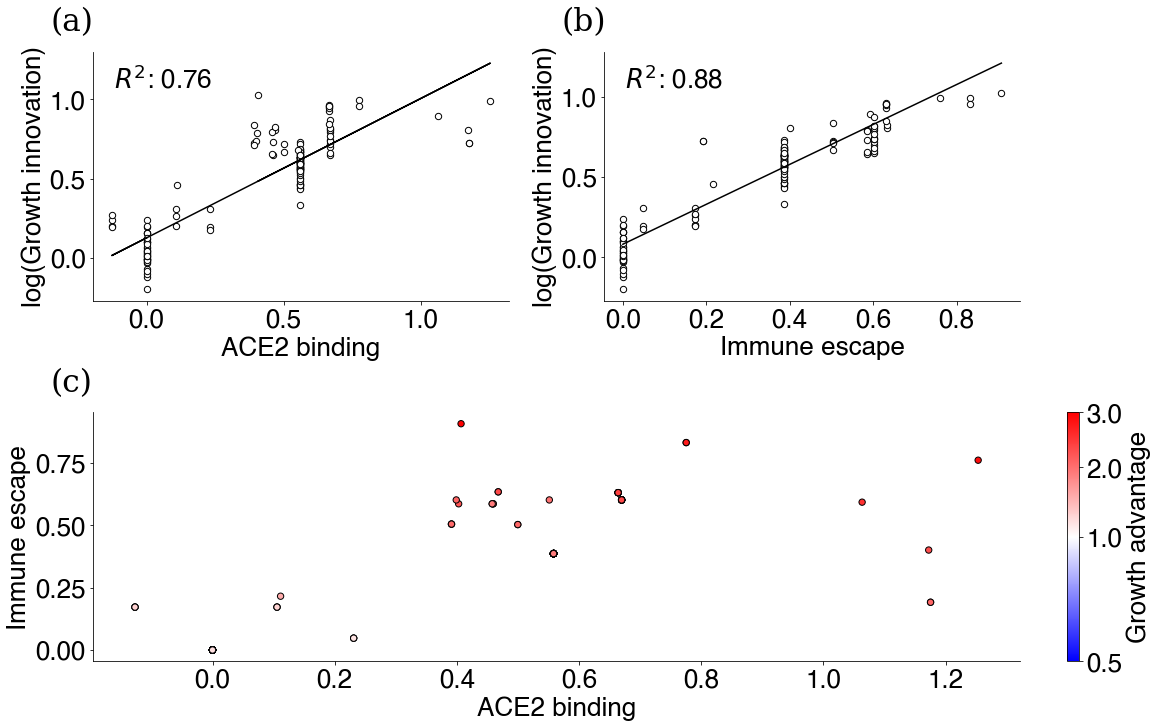

In [26]:
fig = plt.figure(figsize=(16, 10),  constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)

df = escape_scores.reset_index().merge(ga_df, how="left")[:-1]
log_ga = np.log(df.median_ga.values)
ga = df.median_ga.values

# Delta ACE2 v. Relative Fitness
ax_binding = fig.add_subplot(gs[0,0]); simple_axis(ax_binding)
ax_binding.scatter(df.ace2_binding, log_ga, ec = "k", color="w", s=40)
add_regression(ax_binding, df.ace2_binding.values, log_ga,)
ax_binding.set_xlabel("ACE2 binding")
ax_binding.set_ylabel("log(Growth innovation)")

# Delta Immune escape v. Relative Fitness
ax_es = fig.add_subplot(gs[0,1]); simple_axis(ax_es)
ax_es.scatter(df.immune_escape, log_ga, ec = "k", color="w", s=40)
add_regression(ax_es, df.immune_escape.values, log_ga,)

ax_es.set_xlabel("Immune escape")
ax_es.set_ylabel("log(Growth innovation)")

# Delta ACE2 v. Delta Immune escape
ax_both = fig.add_subplot(gs[1,:]); simple_axis(ax_both)
divnorm = MidpointNormalize(midpoint = 1.0, vmin = np.nanmin(ga), vmax = np.nanmax(ga))

cax = ax_both.scatter(x=df.ace2_binding, y=df.immune_escape, 
           c=ga, cmap=cmap, norm = divnorm, ec = "k", s=40)
ax_both.set_xlabel("ACE2 binding")
ax_both.set_ylabel("Immune escape")

cbar = fig.colorbar(cax, label="Growth advantage")
cbar.set_ticks([0.5, 1.0, 2.0, 3.0])

# Adding panel labels
axs = [ax_binding, ax_es, ax_both]
labels = ["(a)", "(b)", "(c)"]
    
for label, ax in zip(labels, axs):
    trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

In [ ]:
fig.savefig("figures/binding-escape-score-growth-advantage.png")